In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from progressbar import ProgressBar
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
Nbasins=154
Ndatasets=891
data_TWS='GRACE_JPL_mascons'

NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

In [3]:
no_datasets=NSE_tab.columns[np.where(NSE_tab.columns.str[:2]!='P_')]
datasets=NSE_tab.columns[np.where(NSE_tab.columns.str[:2]=='P_')]

# 1. What does 'excellent' mean compared to 'very good'?

In [4]:
def get_Afilter_perf(basin_name,b1,b2,method='median'):
    selection=NSE_tab.loc[basin_name,datasets[(NSE_tab.loc[basin_name,datasets]>=b1)&(NSE_tab.loc[basin_name,datasets]<=b2)]]
    if method=='median':
        #combination=selection.index[np.where(selection==np.percentile(selection,50))[0][0]]
        combination=selection.sort_values().index[selection.shape[0]//2]
    if method=='max':
        combination=selection.index[np.argmax(selection)]
        
    print(combination)
    (data_P,data_ET,data_R,data_TWS)=decompose_dataset(combination)

    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])

    ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
    time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])

    R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
    time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 

    time_idx=pd.date_range(max(time_P.min(),time_ET.min(),time_R.min()),
                           min(time_P.max(),time_ET.max(),time_R.max()),
                           freq='SM')[::2]

    P_filter=P_month.loc[basin_name,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
    ET_filter=ET_month.loc[basin_name,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
    R_filter=R_month.loc[basin_name,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]

    fillingP=(np.sum(np.isnan(P_filter))==0)
    fillingET=(np.sum(np.isnan(ET_filter))==0)
    fillingR=(np.sum(np.isnan(R_filter))==0)

    if fillingP&fillingET&fillingR: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
        A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
    else:
        print('This basin is not entirely covered')
        
    return A_filter,time_idx

In [5]:
def get_TWSC_filter(basin_name,data_TWS):
    TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

    TWSC_filter=TWS_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_TWS]]
    TWSC_filter.index=time_TWS
    
    if data_TWS=='GRACE_JPL_mascons':
        TWS_uncertainty_month=pd.read_csv('../results/hydrology/TWS_uncertainty_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
        TWSC_uncertainty_filter=TWS_uncertainty_month.loc[basin_name,['TWS_uncertainty_{} {}'.format(data_TWS,d.date()) for d in time_TWS]]
        TWSC_uncertainty_filter.index=time_TWS
        return TWSC_filter,TWSC_uncertainty_filter

    return TWSC_filter,False

In [6]:
basin_name='RIO TAPAJOS'

TWSC,D_TWSC=get_TWSC_filter(basin_name,data_TWS)
A_vg,time_vg=get_Afilter_perf(basin_name,0.75,1)
A_g,time_g=get_Afilter_perf(basin_name,0.5,0.75)
A_p,time_p=get_Afilter_perf(basin_name,0.2,0.5)
time_idx=TWSC.index.intersection(time_vg).intersection(time_g).intersection(time_p)

P_GPCC_ET_GLDAS20_NOAH36_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons
P_MERRA2_ET_SSEBop_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons
P_MSWEP_ET_MERRA2_R_GLDAS20_NOAH36_TWS_GRACE_JPL_mascons


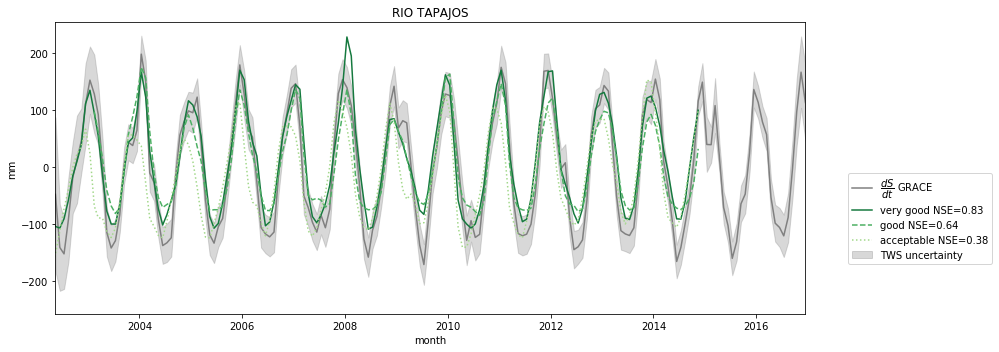

In [7]:
cmap_NSE=define_cmap_perf('NSE')[1]

plt.figure(figsize=(14,5))
plt.plot(TWSC,color='gray',label='$\dfrac{dS}{dt}$ GRACE')
plt.fill_between(TWSC.index,TWSC-D_TWSC,TWSC+D_TWSC,color='gray',alpha=0.3,label='TWS uncertainty')
#NSE_best=compute_NSE(A_best[time_idx],TWSC[time_idx])
#plt.plot(A_best,linewidth=3,color=cmap_NSE(NSE_best),label='best NSE={:.2f}'.format(NSE_best))
plt.plot(A_vg,color=cmap_NSE(0.8),label='very good NSE={:.2f}'.format(compute_NSE(A_vg[time_idx],TWSC[time_idx])))
plt.plot(A_g,'--',color=cmap_NSE(0.6),label='good NSE={:.2f}'.format(compute_NSE(A_g[time_idx],TWSC[time_idx])))
plt.plot(A_p,':',color=cmap_NSE(0.4),label='acceptable NSE={:.2f}'.format(compute_NSE(A_p[time_idx],TWSC[time_idx])))

#plt.xlim([time_idx[0],time_idx[-1]])
plt.xlim([TWSC.index[0],date(2016,12,15)])
#plt.ylim([1.05*np.min(TWSC[time_idx]-D_TWSC[time_idx]),1.05*np.max(TWSC[time_idx]+D_TWSC[time_idx])])
#plt.ylim([-90,100])
plt.ylabel('mm')
plt.xlabel('month')
plt.title(basin_name)
plt.legend(bbox_to_anchor=(1.05,0.5))
plt.tight_layout()
plt.show()

# 2. Select the combination providing the largest number of 'good' basins

There are -9999 when ET is negative, we replace by nan to not influence the statistics

In [8]:
stats_NSE_tab=np.sum(NSE_tab[datasets]>=0.75,axis=0).to_frame(name='very good').T
stats_NSE_tab.loc['good']=np.sum(NSE_tab[datasets]>=0.5,axis=0)
stats_NSE_tab.loc['acceptable']=np.sum(NSE_tab[datasets]>=0.2,axis=0)
stats_NSE_tab.loc['poor']=np.sum(NSE_tab[datasets]<0.2,axis=0)

In [9]:
stats_NSE_tab

,P_CPC_ET_ERA5_Land_R_ERA5_Land_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS20_NOAH36_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS20_VIC412_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS21_CLSM25_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS21_VIC412_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GRUN_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_MERRA2_TWS_GRACE_JPL_mascons,P_CPC_ET_GLDAS20_CLSM25_R_ERA5_Land_TWS_GRACE_JPL_mascons,...,P_TRMM_ET_MOD16_R_MERRA2_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_ERA5_Land_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS20_NOAH36_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS20_VIC412_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS21_CLSM25_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS21_VIC412_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GRUN_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_MERRA2_TWS_GRACE_JPL_mascons
very good,6,10,5,2,5,2,1,8,10,9,...,2,10,14,11,3,11,8,1,23,12
good,45,40,33,15,38,24,15,42,55,50,...,27,48,45,42,23,40,37,23,58,45
acceptable,78,63,65,53,63,68,57,86,86,92,...,48,71,76,69,43,73,74,44,82,78
poor,65,74,72,84,74,74,80,57,57,45,...,27,26,26,33,59,29,30,58,22,26


We define the best datasets combination as the one with the largest number of basins performing at least good

In [10]:
best_comb=datasets[np.argmax(stats_NSE_tab.loc['good',datasets])]
best_comb

'P_GPCP_ET_GLDAS21_CLSM25_R_GRUN_TWS_GRACE_JPL_mascons'

In [11]:
temp_max=NSE_tab[best_comb]
print('{} gives : \n {} basins very good (NSE >=0.75) \n {} basins good (NSE >=0.5) \n {} basins acceptable (NSE>=0.2) \n {} basins poor (NSE<0.2) \n {} basins unknown'.format(best_comb,np.sum(temp_max>=0.75),
                np.sum(temp_max>=0.5),
                np.sum(temp_max>=0.2),
                temp_max.loc[temp_max<0.2].shape[0],
                np.sum(np.isnan(temp_max)),
                ))

P_GPCP_ET_GLDAS21_CLSM25_R_GRUN_TWS_GRACE_JPL_mascons gives : 
 39 basins very good (NSE >=0.75) 
 108 basins good (NSE >=0.5) 
 137 basins acceptable (NSE>=0.2) 
 11 basins poor (NSE<0.2) 
 6 basins unknown


Show other satisfying combinations

In [17]:
np.where(stats_NSE_tab.loc['good',datasets]>=105)[0]

array([439, 440, 547], dtype=int64)

In [22]:
best_comb=datasets[547]
best_comb

'P_GPM_ET_GLDAS21_NOAH36_R_GRUN_TWS_GRACE_JPL_mascons'

In [23]:
temp_max=NSE_tab[best_comb]
print('{} gives : \n {} basins very good (NSE >=0.75) \n {} basins good (NSE >=0.5) \n {} basins acceptable (NSE>=0.2) \n {} basins poor (NSE<0.2) \n {} basins unknown'.format(best_comb,np.sum(temp_max>=0.75),
                np.sum(temp_max>=0.5),
                np.sum(temp_max>=0.2),
                temp_max.loc[temp_max<0.2].shape[0],
                np.sum(np.isnan(temp_max)),
                ))

P_GPM_ET_GLDAS21_NOAH36_R_GRUN_TWS_GRACE_JPL_mascons gives : 
 32 basins very good (NSE >=0.75) 
 106 basins good (NSE >=0.5) 
 131 basins acceptable (NSE>=0.2) 
 21 basins poor (NSE<0.2) 
 2 basins unknown


Plot world map with the performance color for each basin.

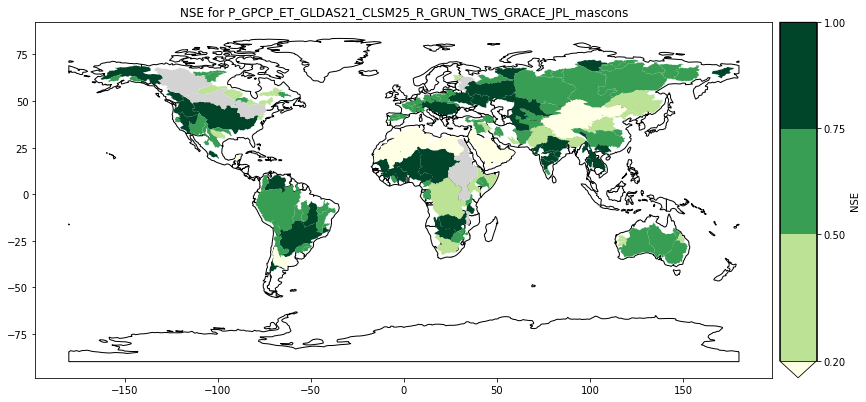

In [13]:
basins=load_basins_data()
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

selected_basins_plot=basins.loc[NSE_tab.index]
selected_basins_plot['best comb']=NSE_tab[best_comb]
#selected_basins_plot['best comb']=np.where(NSE_tab[best_comb]<0.2,np.nan,NSE_tab[best_comb])

norm,cmap=define_cmap_perf('NSE_large')

fig, ax = plt.subplots(figsize=(14,7))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='white', edgecolor='black')
selected_basins_plot.plot(ax=ax,column='best comb',legend=True,cax=cax,missing_kwds={"color": "lightgrey",},
                          #legend_kwds={'label': "NSE",'extend':'min'},
                         cmap=cmap,norm=norm)
fig.colorbar(
    ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    boundaries=[0] + [0.2,0.5,0.75,1],  # Adding values for extensions.
    extend='min',
    ticks=[0.2,0.5,0.75,1],
    spacing='proportional',
    label='NSE',
)
ax.set_title("NSE for {}".format(best_comb))
plt.show()

Are unknown basins always poor?

In [14]:
NSE_tab.loc[np.isnan(NSE_tab[best_comb]),datasets].max(axis=1)

NAME
ST.LAWRENCE        0.812181
MACKENZIE RIVER    0.900168
NILE               0.862928
SHIRE              0.915956
NEVA               0.746039
NELSON RIVER       0.844783
dtype: float64

Who are the poor basins?

In [15]:
NSE_tab.loc[NSE_tab[best_comb]<0.2,datasets].max(axis=1)

NAME
COLORADO (ARGENTINIA)     0.478601
SALADO                    0.572489
ARGENTINIA (DL)           0.531883
YUCATAN (DL)              0.682731
SAUDI ARABIA (DL)         0.198862
TARIM (DL)                0.106842
NORTH CHINA (DL)          0.336284
HIGHLAND OF TIBET (DL)    0.714142
GOBI (DL)                -0.010426
WESTERN SAHARA (DL)       0.236860
NORTHERN SAHARA (DL)     -0.293542
dtype: float64

# 3. About the NSE scale

In [16]:
basin_name='COPPER RIVER'
data_TWS='GRACE_JPL_mascons'
TWSC,D_TWSC=get_TWSC_filter(basin_name,data_TWS)

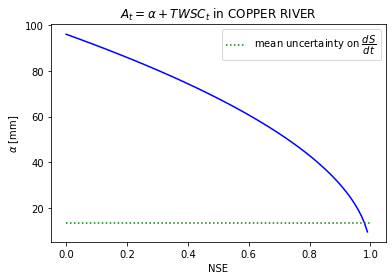

In [17]:
vecNSE=np.arange(0,1,0.01)
time_precise=pd.date_range(start=date(2004,1,1),end=date(2016,1,1),freq='SM')[::2]
alpha=np.sqrt(1-vecNSE)*np.sqrt(np.sum((TWSC-TWSC.mean())**2)/TWSC.shape[0])
bound=D_TWSC[time_precise].mean()

plt.figure()
plt.plot(vecNSE,alpha,'b')
plt.plot([0,1],[bound]*2,'g:',label='mean uncertainty on $\dfrac{dS}{dt}$')
plt.xlabel('NSE')
plt.ylabel(r'$\alpha$ [mm]')
plt.title(r'$A_t=\alpha+TWSC_t$ in '+basin_name)
plt.legend()
plt.show()

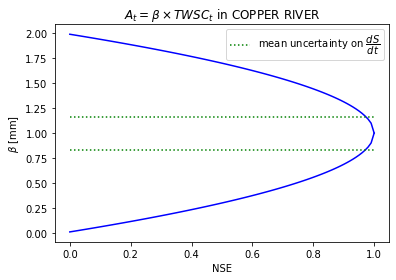

In [18]:
vecNSE=np.arange(0,1.01,0.01)
time_precise=pd.date_range(start=date(2004,1,1),end=date(2016,1,1),freq='SM')[::2]
beta1=1+np.sqrt(1-vecNSE)*np.sqrt(np.sum((TWSC-TWSC.mean())**2)/np.sum(TWSC**2))
beta2=1-np.sqrt(1-vecNSE)*np.sqrt(np.sum((TWSC-TWSC.mean())**2)/np.sum(TWSC**2))
bound1=1+D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
bound2=1-D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()

plt.figure()
plt.plot(vecNSE,beta1,'b')
plt.plot(vecNSE,beta2,'b')
plt.plot([0,1],[bound1,bound1],'g:',label='mean uncertainty on $\dfrac{dS}{dt}$')
plt.plot([0,1],[bound2,bound2],'g:')
plt.xlabel('NSE')
plt.ylabel(r'$\beta$ [mm]')
plt.title(r'$A_t=\beta \times TWSC_t$ in '+basin_name)
plt.legend()
plt.show()

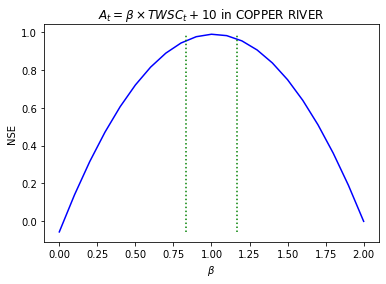

In [19]:
alpha=10

vec_beta=np.arange(0,2.1,0.1)
BY=(vec_beta-1).reshape(vec_beta.shape[0],1).dot((TWSC[time_precise].values).reshape(1,time_precise.shape[0]))
vec_NSE=1-np.sum((BY+alpha)**2,axis=1)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)

bound1=1+D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
bound2=1-D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()

plt.figure()
plt.plot(vec_beta,vec_NSE,'b')
plt.plot([bound1,bound1],[vec_NSE.min(),vec_NSE.max()],'g:')
plt.plot([bound2,bound2],[vec_NSE.min(),vec_NSE.max()],'g:')
plt.xlabel(r'$\beta$')
plt.ylabel('NSE')
plt.title(r'$A_t=\beta \times TWSC_t + {}$ in {}'.format(alpha,basin_name))
plt.show()

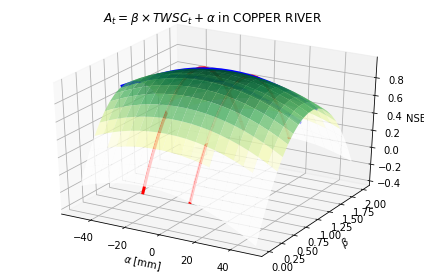

In [20]:
from mpl_toolkits.mplot3d import Axes3D

avec=np.linspace(-50,50,20)
bvec=np.arange(0,2.1,0.1)
(Avec,Bvec)=np.meshgrid(avec,bvec)
temp=np.zeros_like(Avec,dtype=float)
for t in time_precise:
    temp+=((Bvec-1)*TWSC.loc[t]+Avec)**2
NSE_vec=1-temp/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Avec,Bvec,NSE_vec,cmap=define_cmap_perf('NSE',discrete=False)[1],alpha=0.8)


bound_alpha=D_TWSC[time_precise].mean()
BY=(bvec-1).reshape(bvec.shape[0],1).dot((TWSC[time_precise].values).reshape(1,time_precise.shape[0]))
NSE_bound=1-np.sum((BY+bound_alpha)**2,axis=1)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)
ax.plot(bound_alpha*np.ones_like(bvec),bvec,NSE_bound,linewidth=3,color='red')
ax.plot(-bound_alpha*np.ones_like(bvec),bvec,NSE_bound,linewidth=3,color='red')

bound_beta1=1+D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
bound_beta2=1-D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
NSE_bound1=np.zeros_like(avec)
NSE_bound2=np.zeros_like(avec)
for i,alpha in enumerate(avec):
    NSE_bound1[i]=1-np.sum((((bound_beta1-1)*TWSC[time_precise])+alpha)**2)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)
    NSE_bound2[i]=1-np.sum((((bound_beta2-1)*TWSC[time_precise])+alpha)**2)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)
ax.plot(avec,bound_beta1*np.ones_like(avec),NSE_bound1,linewidth=3,color='blue')
ax.plot(avec,bound_beta2*np.ones_like(avec),NSE_bound2,linewidth=3,color='blue')


ax.set_xlabel(r'$\alpha$ [mm]')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('NSE')
ax.set_title(r'$A_t=\beta \times TWSC_t + \alpha$ in '+basin_name)
#ax.set_zlim([0,1])

fig.tight_layout()
plt.show()

# 4. What makes a good basin?

In [21]:
Nbasins=154
Ndatasets=891
data_TWS='GRACE_JPL_mascons'

NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

no_datasets=NSE_tab.columns[np.where(NSE_tab.columns.str[:2]!='P_')]
datasets=NSE_tab.columns[np.where(NSE_tab.columns.str[:2]=='P_')]

In [22]:
NSE_tab[datasets]=pd.DataFrame(np.where(NSE_tab[datasets]==-9999,np.nan,NSE_tab[datasets]),
                               index=NSE_tab.index,columns=datasets)

In [23]:
#Y=NSE_tab[datasets].mean(axis=1)
Y=NSE_tab[datasets].median(axis=1)
Y

NAME
KHATANGA                   0.527672
ODER RIVER                 0.550821
ELBE RIVER                 0.534856
COLUMBIA RIVER             0.803539
RHINE                      0.573877
                             ...   
CHURCHILL, FLEUVE (LABR    0.457491
DNIEPR                     0.662628
URAL                       0.632404
WISLA                      0.533763
DON                        0.673645
Length: 154, dtype: float64

In [24]:
X=NSE_tab[['MAIN_CLIMATE','CLIMATE_AREA_%','RASTAREA','NB_RUNOFF']].copy()
X['NB_RUNOFF']=X['NB_RUNOFF'].astype(float)

X['RASTAREA']=X['RASTAREA']/1e4

# transform climate to integers to perform the regression
X['MAIN_CLIMATE']=np.where(X['MAIN_CLIMATE']=='A',0,X['MAIN_CLIMATE'])
X['MAIN_CLIMATE']=np.where(X['MAIN_CLIMATE']=='B',1,X['MAIN_CLIMATE'])
X['MAIN_CLIMATE']=np.where(X['MAIN_CLIMATE']=='C',2,X['MAIN_CLIMATE'])
X['MAIN_CLIMATE']=np.where(X['MAIN_CLIMATE']=='D',3,X['MAIN_CLIMATE'])
X['MAIN_CLIMATE']=np.where(X['MAIN_CLIMATE']=='E',4,X['MAIN_CLIMATE'])
X['MAIN_CLIMATE']=X['MAIN_CLIMATE'].astype(int)

X['intercept']=1.0
X

,MAIN_CLIMATE,CLIMATE_AREA_%,RASTAREA,NB_RUNOFF,intercept
NAME,,,,,
KHATANGA,3,91.129714,26.558070,0.0,1.0
ODER RIVER,2,94.763680,10.729780,53.0,1.0
ELBE RIVER,2,96.768446,13.403670,69.0,1.0
COLUMBIA RIVER,3,52.542464,66.254170,153.0,1.0
RHINE,2,91.162177,16.970610,188.0,1.0
...,...,...,...,...,...
"CHURCHILL, FLEUVE (LABR",3,98.478684,8.665833,2.0,1.0
DNIEPR,3,99.855605,45.658760,1.0,1.0
URAL,3,97.769008,19.409500,0.0,1.0


In [25]:
def compute_mean_annual_hydro(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap[:-1]]].to_frame()
    hydro_basin.index=time_overlap[:-1]
    hydro_basin['month']=hydro_basin.index.month
    hydro_basin_mean=hydro_basin.groupby('month').mean()
    hydro_basin_std=hydro_basin.groupby('month').std()
    # transform to Series
    hydro_basin_mean=pd.Series(hydro_basin_mean.values.flatten(),index=np.arange(1,13),name=basin_name)
    hydro_basin_std=pd.Series(hydro_basin_std.values.flatten(),index=np.arange(1,13),name=basin_name)
    return hydro_basin_mean,hydro_basin_std

In [26]:
min_year=2002
max_year=2016
month_start=5 # data computed from May to April
time_overlap=pd.date_range(start=date(min_year,month_start,1),end=date(max_year,month_start+1,1),freq='SM')[::2]

In [27]:
TWS_month=pd.read_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format('TWS',data_TWS),
                                                            index_col=[0])
for basin_name in X.index:
    TWS_mean,TWS_std=compute_mean_annual_hydro(TWS_month,'TWS',data_TWS,basin_name,time_overlap)
    X.loc[basin_name,'magnitude']=TWS_mean.max()-TWS_mean.min()
    X.loc[basin_name,'noise']=TWS_std.max()

X['signal_to_noise']=X['magnitude']/X['noise']

In [28]:
X

,MAIN_CLIMATE,CLIMATE_AREA_%,RASTAREA,NB_RUNOFF,intercept,magnitude,noise,signal_to_noise
NAME,,,,,,,,
KHATANGA,3,91.129714,26.558070,0.0,1.0,74.824000,15.984230,4.681114
ODER RIVER,2,94.763680,10.729780,53.0,1.0,49.626336,19.761009,2.511326
ELBE RIVER,2,96.768446,13.403670,69.0,1.0,47.156951,17.034518,2.768317
COLUMBIA RIVER,3,52.542464,66.254170,153.0,1.0,138.761564,20.759422,6.684269
RHINE,2,91.162177,16.970610,188.0,1.0,75.883036,21.612917,3.511004
...,...,...,...,...,...,...,...,...
"CHURCHILL, FLEUVE (LABR",3,98.478684,8.665833,2.0,1.0,122.451012,36.279679,3.375196
DNIEPR,3,99.855605,45.658760,1.0,1.0,68.809769,17.686509,3.890523
URAL,3,97.769008,19.409500,0.0,1.0,64.806897,18.218350,3.557232


In [29]:
from statsmodels.api import OLS

In [30]:
res = OLS(Y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     6.934
Date:                Tue, 01 Dec 2020   Prob (F-statistic):           3.98e-07
Time:                        10:48:14   Log-Likelihood:                -23.148
No. Observations:                 154   AIC:                             62.30
Df Residuals:                     146   BIC:                             86.59
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
MAIN_CLIMATE        0.0642      0.025      2.572      0.011       0.015       0.114
CLIMATE_AREA_%     -0.0002      0.001     -0.147      0.883      -0.003       0.002
RASTAREA           -0.0011      0.000     -3.151      0.002      -0.002      -0.000
NB_RUNOFF           0.0009      0.001      1.776      0.078      -0.000       0.002
intercept          -0.1217      0.157     -0.777      0.438      -0.431       0.188
magnitude          -0.0031      0.001     -2.635      0.009      -0.006      -0.001
noise               0.0108      0.004      2.606      0.010       0.003       0.019
signal_to_noise     0.1170      0.031      3.819      0.000       0.056       0.178
==============================================================================
Omnibus:                       70.819   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.357
Skew:                          -1.814   Prob(JB):                     7.82e-52
Kurtosis:                       7.849   Cond. No.                         972.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
res.predict(X.sort_values(by='RASTAREA'))

NAME
JEQUITINHONHA           0.350566
DNIESTR                 0.412205
KARUN                   0.381113
VUOKSI                  0.397193
NOTTAWAY                0.505459
                          ...   
NILE                    0.113782
LAKE CHAD (DL)          0.324025
NORTHERN SAHARA (DL)   -0.285529
CONGO                   0.001843
AMAZONAS                0.050916
Length: 154, dtype: float64

In [32]:
sort_value='RASTAREA'
temp=NSE_tab.sort_values(by=sort_value)[datasets].copy()
NSE_tab_without_nan=[]
for x in temp.values:
    NSE_tab_without_nan.append(x[~np.isnan(x)])

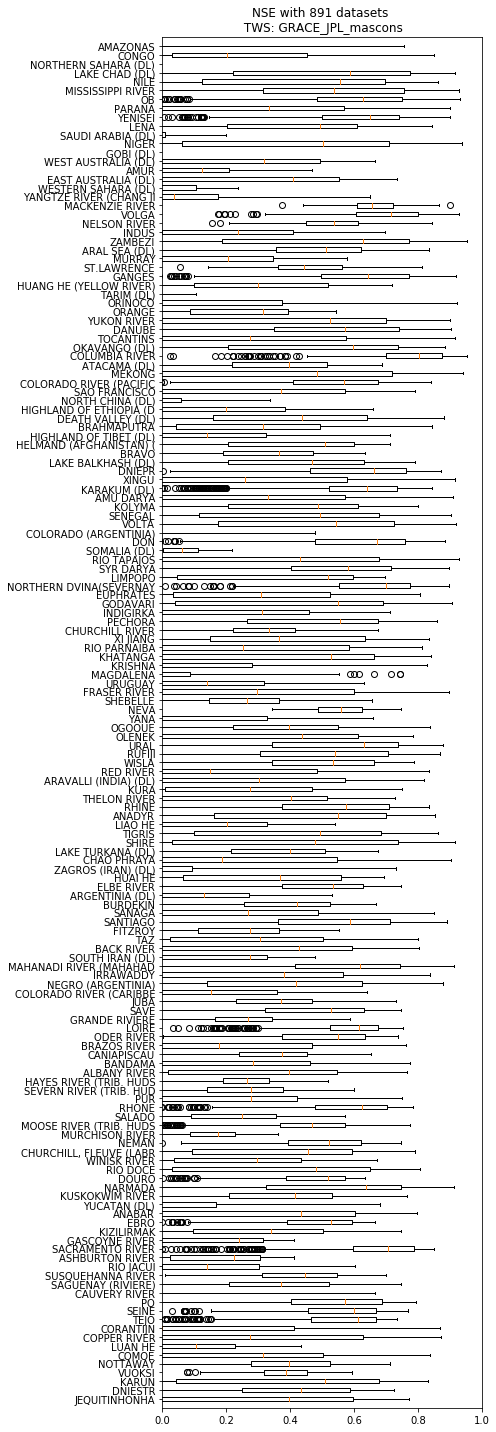

In [33]:
plt.figure(figsize=(7,20))
plt.boxplot(NSE_tab_without_nan,vert=False,labels=temp.index)
#plt.boxplot(NSE_tab_without_nan,vert=False)

#plt.plot(Y,np.arange(1,NSE_tab.shape[0]+1),'+')
#plt.plot(res.predict(X.sort_values(by='RASTAREA')),np.arange(1,NSE_tab.shape[0]+1),'r.')

plt.title('NSE with {} datasets \n TWS: {}'.format(len(datasets),data_TWS))
plt.xlim([0,1])
plt.ylim([0,155])
plt.tight_layout()
plt.show()

In [34]:
Y=NSE_tab[datasets].mean(axis=1)
#Y=NSE_tab[datasets].median(axis=1)
Y=np.sum(NSE_tab[datasets]>=0.5,axis=1)

In [35]:
for col in X.columns:
    print('{} : correation={:.2f}'.format(col,np.corrcoef(X[col],Y)[0,1]))

MAIN_CLIMATE : correation=0.09
CLIMATE_AREA_% : correation=-0.09
RASTAREA : correation=-0.08
NB_RUNOFF : correation=0.15
intercept : correation=nan
magnitude : correation=0.32
noise : correation=0.23
signal_to_noise : correation=0.37


c:\users\fafal\miniconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\fafal\miniconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
